In [1]:
# Importing Libraries 

import pandas as pd
import numpy as np
import math
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from pyomo.environ import *
import matplotlib.pyplot as plt

In [2]:
from __future__ import division
from pyomo.opt import SolverFactory

In [3]:
# Reading the data from Excel workbook
InputData = "Staffing+Data.xlsx"

#Read the data from DemandData sheet
DemandData = pd.read_excel(InputData,sheet_name='DemandData')

#Read the data from StaffAvailability sheet
StaffAvailability = pd.read_excel (InputData,sheet_name='StaffAvailability')

#Read the data from cost sheet 
## cost includes both salary and outsource cost
cost = pd.read_excel (InputData,sheet_name='Cost')

#Service rate = 40 
ServiceRate = pd.read_excel (InputData,sheet_name='ServiceRate')




In [4]:
#Printing the dataframe 
DemandData

,State,Month,Demand
0,A,Jan,5240
1,A,Feb,4878
2,A,Mar,5942
3,A,Apr,2297
4,A,May,1992
5,A,Jun,2275
6,A,Jul,5334
7,A,Aug,3371
8,A,Sep,3759
9,A,Oct,3529


In [5]:
#Printing the dataframe of staffavailiability
StaffAvailability

,State,Month,LB,UB,StaffAvPer
0,A,Jan,0.70,0.90,0.81
1,A,Feb,0.65,0.85,0.76
2,A,Mar,0.70,0.80,0.75
3,A,Apr,0.75,0.85,0.80
4,A,May,0.70,0.85,0.78
5,A,Jun,0.65,0.80,0.73
6,A,Jul,0.60,0.75,0.68
7,A,Aug,0.65,0.85,0.76
8,A,Sep,0.70,0.90,0.81
9,A,Oct,0.65,0.80,0.73


In [6]:
#Printing the dataframe of cost
cost

,State,Month,AnnualSalary,MonthlySalary,UnitOutSourceCost
0,A,Jan,60000,5000.000000,180
1,A,Feb,60000,5000.000000,180
2,A,Mar,60000,5000.000000,180
3,A,Apr,60000,5000.000000,180
4,A,May,60000,5000.000000,180
5,A,Jun,60000,5000.000000,180
6,A,Jul,60000,5000.000000,180
7,A,Aug,60000,5000.000000,180
8,A,Sep,60000,5000.000000,180
9,A,Oct,60000,5000.000000,180


## Data pre-processing 

In [7]:
# Create the required Python data structures for indexes and parameters

# Converting demand data as a dictionary wrt to month and location 
demand = DemandData.set_index(['State', 'Month'])['Demand'].to_dict()

# Converting salary as a dictionary wrt to month and location
FTE_Salary=cost.set_index(['State', 'Month'])['MonthlySalary'].to_dict()

# Converting outsource cost as a dictionary wrt to month and location
UnitOutSourceCost= cost.set_index(['State', 'Month'])['UnitOutSourceCost'].to_dict()

# Number of application when Employee working full time i.e 100% utilization i.e. 40
FTE_AppServeRate= ServiceRate.iloc[0,0]

#staff Availability for serving the insurance Application
# UB indicates upper bound which is the best case scenario
# LB indicates lower bound which is the worst case scenario
Staff_LB= StaffAvailability.set_index(['State', 'Month'])['LB'].to_dict()
Staff_UB= StaffAvailability.set_index(['State', 'Month'])['UB'].to_dict()
StaffAvPer= StaffAvailability.set_index(['State', 'Month'])['StaffAvPer'].to_dict()

# Index i.e State A,B,C and 12 months
BankLoc=cost['State'].unique()
Month=cost['Month'].unique()


# Question 1

The company wants to know the optimised staffing recommendations for the business case described. 
Write the mathematical model for the deterministic optimisation problem. Define and explain your decision variables, objective function and the constraint. (Hint: Use months of the year as the model timeline).



1. **Decision Variables are** : No. of FTEs(Full Time equivalents)i.e. the company staff and No. of outsourced applications


2. **Objective functions** = Sum total of Salary of company staff and outsourced applications cost. 
    
        Total expense = Total salary of staff + Outsource cost 
    
        Total salary of company staff = Staff availiability * 40 * salary * No. of FTEs(i.e.staff) 
    
        Outsource amount = Outsource cost * No. of applications outsourced. 
  
      **The total expense is to be minimized.** 
  
  
3. **Constraints** 
    There are two constraints
           
           
       a.  Demand Constraints : 
           The sum total of outsourced and inhouse applications must be equal to demand per state per location
           
           
       b.  Outsource Constraints: 
           1. State A cannot outsource more than 30% total applications per month
           2. State B cannot outsource more than 40% of total applications per month. 
           
           The total no. of applications is nothing but the demand per month. 

**Note:** You can write the mathematical formulation directly in your report.

# Question 2

Code the problem is Python and use any optimization package to solve it. Add comments to your code to explain each step. 

#### Expected output:

Create a data frame containing the number of outsourced applications  and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. 

In [8]:
#Instantiating a model

model = ConcreteModel()


In [9]:
# Define Pyomo sets and Parameters
# states A,B,C and 12 months are the indexes

model.location = Set(initialize = BankLoc.tolist(),doc = 'States') ## creating an index of location 
model.months = Set(initialize = Month.tolist(),doc = 'Months') ## creating an index of month


In [10]:
## demand, salary, outsource cost and staff availiability are parameters in this casestudy. 

model.demand = Param(model.location,model.months, initialize = demand, doc='Demands') #demand is declared as a parameter

# declaring the parameter Salary
model.salary = Param(model.location,model.months, initialize = FTE_Salary, doc = 'Salary')

# declaring the parameter Outsource
model.outsource = Param(model.location, model.months, initialize = UnitOutSourceCost, doc = 'Outsource')

## declaring the parameter Availiability
model.availiability = Param(model.location, model.months, initialize = StaffAvPer, doc = 'Staff Availiability')


In [11]:
model.demand.display() # displaying the demand data dictionary.
# for the state A in APRIL, demand is 2297

demand : Demands
    Size=36, Index=demand_index, Domain=Any, Default=None, Mutable=False
    Key          : Value
    ('A', 'Apr') :  2297
    ('A', 'Aug') :  3371
    ('A', 'Dec') :  5183
    ('A', 'Feb') :  4878
    ('A', 'Jan') :  5240
    ('A', 'Jul') :  5334
    ('A', 'Jun') :  2275
    ('A', 'Mar') :  5942
    ('A', 'May') :  1992
    ('A', 'Nov') :  4284
    ('A', 'Oct') :  3529
    ('A', 'Sep') :  3759
    ('B', 'Apr') :  2338
    ('B', 'Aug') :  2620
    ('B', 'Dec') :  4227
    ('B', 'Feb') :  2628
    ('B', 'Jan') :  4927
    ('B', 'Jul') :  4271
    ('B', 'Jun') :  3147
    ('B', 'Mar') :  2974
    ('B', 'May') :  4020
    ('B', 'Nov') :  3137
    ('B', 'Oct') :  4155
    ('B', 'Sep') :  4517
    ('C', 'Apr') :  2261
    ('C', 'Aug') :  2496
    ('C', 'Dec') :  1998
    ('C', 'Feb') :  1967
    ('C', 'Jan') :  1162
    ('C', 'Jul') :  2489
    ('C', 'Jun') :  1642
    ('C', 'Mar') :  1898
    ('C', 'May') :  2030
    ('C', 'Nov') :   963
    ('C', 'Oct') :  2421
    ('C', 

In [12]:
model.salary.display() ## displaying monthly salary for each state and each month

salary : Salary
    Size=36, Index=salary_index, Domain=Any, Default=None, Mutable=False
    Key          : Value
    ('A', 'Apr') :            5000.0
    ('A', 'Aug') :            5000.0
    ('A', 'Dec') :            5000.0
    ('A', 'Feb') :            5000.0
    ('A', 'Jan') :            5000.0
    ('A', 'Jul') :            5000.0
    ('A', 'Jun') :            5000.0
    ('A', 'Mar') :            5000.0
    ('A', 'May') :            5000.0
    ('A', 'Nov') :            5000.0
    ('A', 'Oct') :            5000.0
    ('A', 'Sep') :            5000.0
    ('B', 'Apr') : 4583.333333333333
    ('B', 'Aug') : 4583.333333333333
    ('B', 'Dec') : 4583.333333333333
    ('B', 'Feb') : 4583.333333333333
    ('B', 'Jan') : 4583.333333333333
    ('B', 'Jul') : 4583.333333333333
    ('B', 'Jun') : 4583.333333333333
    ('B', 'Mar') : 4583.333333333333
    ('B', 'May') : 4583.333333333333
    ('B', 'Nov') : 4583.333333333333
    ('B', 'Oct') : 4583.333333333333
    ('B', 'Sep') : 4583.33333333333

In [13]:
model.outsource.display() # displaying unit outsource cost

outsource : Outsource
    Size=36, Index=outsource_index, Domain=Any, Default=None, Mutable=False
    Key          : Value
    ('A', 'Apr') :   180
    ('A', 'Aug') :   180
    ('A', 'Dec') :   180
    ('A', 'Feb') :   180
    ('A', 'Jan') :   180
    ('A', 'Jul') :   180
    ('A', 'Jun') :   180
    ('A', 'Mar') :   180
    ('A', 'May') :   180
    ('A', 'Nov') :   180
    ('A', 'Oct') :   180
    ('A', 'Sep') :   180
    ('B', 'Apr') :   150
    ('B', 'Aug') :   150
    ('B', 'Dec') :   150
    ('B', 'Feb') :   150
    ('B', 'Jan') :   150
    ('B', 'Jul') :   150
    ('B', 'Jun') :   150
    ('B', 'Mar') :   150
    ('B', 'May') :   150
    ('B', 'Nov') :   150
    ('B', 'Oct') :   150
    ('B', 'Sep') :   150
    ('C', 'Apr') :   160
    ('C', 'Aug') :   160
    ('C', 'Dec') :   160
    ('C', 'Feb') :   160
    ('C', 'Jan') :   160
    ('C', 'Jul') :   160
    ('C', 'Jun') :   160
    ('C', 'Mar') :   160
    ('C', 'May') :   160
    ('C', 'Nov') :   160
    ('C', 'Oct') :   160
  

In [14]:
model.availiability.display() # displaying availiability cost

availiability : Staff Availiability
    Size=36, Index=availiability_index, Domain=Any, Default=None, Mutable=False
    Key          : Value
    ('A', 'Apr') :   0.8
    ('A', 'Aug') :  0.76
    ('A', 'Dec') :  0.65
    ('A', 'Feb') :  0.76
    ('A', 'Jan') :  0.81
    ('A', 'Jul') :  0.68
    ('A', 'Jun') :  0.73
    ('A', 'Mar') :  0.75
    ('A', 'May') :  0.78
    ('A', 'Nov') :  0.68
    ('A', 'Oct') :  0.73
    ('A', 'Sep') :  0.81
    ('B', 'Apr') :   0.8
    ('B', 'Aug') :  0.76
    ('B', 'Dec') :  0.65
    ('B', 'Feb') :  0.76
    ('B', 'Jan') :  0.81
    ('B', 'Jul') :  0.68
    ('B', 'Jun') :  0.73
    ('B', 'Mar') :  0.75
    ('B', 'May') :  0.78
    ('B', 'Nov') :  0.68
    ('B', 'Oct') :  0.73
    ('B', 'Sep') :  0.81
    ('C', 'Apr') :   0.8
    ('C', 'Aug') :  0.76
    ('C', 'Dec') :  0.65
    ('C', 'Feb') :  0.76
    ('C', 'Jan') :  0.81
    ('C', 'Jul') :  0.68
    ('C', 'Jun') :  0.73
    ('C', 'Mar') :  0.75
    ('C', 'May') :  0.78
    ('C', 'Nov') :  0.68
    ('C',

In [15]:
# Decision variables

## the decision variables are No. of FTE i.e. full time equivalent and No. of outsourced applications per month and per state

model.x = Var(model.location, model.months, domain=NonNegativeReals, doc='No of FTE')
model.y = Var(model.location, model.months, domain=NonNegativeIntegers, doc='No of Outsource App')

In [16]:
# Constraints
## outsource constraints

# for state A, the company cannot outsource more than 30% of total applications 
# for state B, the company cannot outsource more than 40% of the total applications 
# for state C, there are no such constraints

model.out = ConstraintList()
for i in model.location:
    for j in model.months:
        if i == 'A':
            model.out.add(expr = (model.y[i,j] <= 0.30*model.demand[i,j]))
        elif i == 'B':
            model.out.add(expr = model.y[i,j] <= 0.40*model.demand[i,j])
        else:
            model.out.add(expr = model.y[i,j] <= model.demand[i,j])

In [17]:
## demand constraints

# The total applications processed by both staff and outsourced must be equal to total demand
# The applications processed by staff = FTE * FTE_appserverate * staff availiability

model.dmd = ConstraintList()
for i in model.location:
    for j in model.months:
        model.dmd.add(expr = model.y[i,j] + model.x[i,j]*FTE_AppServeRate*model.availiability[i,j] == model.demand[i,j])

In [18]:
# Objective function

# objective function is to minimise the total expenditure on staff and outsource
# expense is defined as salary for staff*applications processed by staff + outsource cost*outsourced applications.
## The expense has to be summed over month and location

def obj_rule(model):
    totalexpense = 0
    for i in model.location:
        for j in model.months:
            expense = (model.x[i,j]*model.salary[i,j])+(model.outsource[i,j]*model.y[i,j])
            totalexpense += expense
    return(totalexpense)


model.objective = Objective(rule = obj_rule, sense = minimize)




In [19]:
# Invoking the solver glpk
result = SolverFactory('glpk').solve(model)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 17962336.4487699
  Upper bound: 17962336.4487699
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 73
  Number of nonzeros: 109
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.031490325927734375
# ----------------------------------------------------------
#   Solution Information
# ----------

In [20]:
# Finding the value of objective function
print('Expense incurred is',int(model.objective()))

Expense incurred is 17962336


In [21]:
# Print the value of the objective function
model.pprint()

10 Set Declarations
    availiability_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain          : Size : Members
        None :     2 : location*months :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    demand_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain          : Size : Members
        None :     2 : location*months :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), (


**`Checkpoint 1:`** Seems like the company has to spend around 17.9 m$ in total for the application approval process.

In [22]:
# Creating dataframe for the results

#Creating an empty list
Output = []

for i in model.location:
    for j in model.months:
        
        #No. of FTEs
        No_of_FTEs = model.x[i,j].value
        
        #outsourced applications
        outsourced =model.y[i,j].value
        
        Salary = model.salary[i,j]
        
        Outsource_cost = model.outsource[i,j]
        
        Total_monthly_cost = (No_of_FTEs*Salary)+(Outsource_cost*outsourced)
        
        Applications_staff = model.x[i,j].value * 40 * model.availiability[i,j]
               
        Output.append([i,j,No_of_FTEs,outsourced,Total_monthly_cost,Applications_staff])
        
print(Output)


[['A', 'Jan', 161.728395061728, 0.0, 808641.97530864, 5239.999999999987], ['A', 'Feb', 160.460526315789, 0.0, 802302.631578945, 4877.999999999985], ['A', 'Mar', 198.066666666667, 0.0, 990333.333333335, 5942.000000000011], ['A', 'Apr', 71.78125, 0.0, 358906.25, 2297.0], ['A', 'May', 63.8461538461538, 0.0, 319230.76923076896, 1991.9999999999986], ['A', 'Jun', 77.9109589041096, 0.0, 389554.794520548, 2275.0000000000005], ['A', 'Jul', 137.279411764706, 1600.0, 974397.05882353, 3734.000000000003], ['A', 'Aug', 110.888157894737, 0.0, 554440.7894736851, 3371.0000000000055], ['A', 'Sep', 116.018518518519, 0.0, 580092.592592595, 3759.000000000016], ['A', 'Oct', 120.856164383562, 0.0, 604280.82191781, 3529.0000000000105], ['A', 'Nov', 110.257352941176, 1285.0, 782586.76470588, 2998.9999999999873], ['A', 'Dec', 139.576923076923, 1554.0, 977604.615384615, 3628.999999999998], ['B', 'Jan', 152.067901234568, 0.0, 696977.8806584367, 4927.000000000004], ['B', 'Feb', 51.875, 1051.0, 395410.4166666666, 1

In [23]:

#Converting a list into a dataframe
## Output dataframe has columns state, month, number of FTEs, Number of outsource, total monthly cost, applications processed by staff

Output = pd.DataFrame(Output,columns=['State', 'Month','Number of FTEs','Number of Outsource','Total Monthly Cost','Applications processed by staff'])



In [24]:
Output.head(10)

,State,Month,Number of FTEs,Number of Outsource,Total Monthly Cost,Applications processed by staff
0,A,Jan,161.728395,0.0,808641.975309,5240.0
1,A,Feb,160.460526,0.0,802302.631579,4878.0
2,A,Mar,198.066667,0.0,990333.333333,5942.0
3,A,Apr,71.781250,0.0,358906.250000,2297.0
4,A,May,63.846154,0.0,319230.769231,1992.0
5,A,Jun,77.910959,0.0,389554.794521,2275.0
6,A,Jul,137.279412,1600.0,974397.058824,3734.0
7,A,Aug,110.888158,0.0,554440.789474,3371.0
8,A,Sep,116.018519,0.0,580092.592593,3759.0
9,A,Oct,120.856164,0.0,604280.821918,3529.0


In [25]:
Total = Output['Total Monthly Cost'].sum()
print('The total cost for underwriting process is',round(Total,2))

The total cost for underwriting process is 17962336.45


In [26]:
# Writing the results in to an Excel sheet

from openpyxl import load_workbook
Output.to_excel(r'C:\Users\Admin\Downloads\Staff_case_study\Staffplanningfin.xlsx')

# Question 3

#### Worst-case and best-case analysis based on the staffs' availability.

Assuming that the distribution is the same across all the states,

#### 3.1 Worst case analysis 

- 3.1.1 What is the optimal number of staff members for the worst and best cases? 

- 3.1.2 What is the percentage of outsourcing for the worst and best cases? 

- 3.1.3 What is the average cost per application for the worst and best cases?


#### 3.2 Best case analysis 

- 3.2.1 What is the optimal number of staff members for the worst and best cases? 

- 3.2.2 What is the percentage of outsourcing for the worst and best cases? 

- 3.2.3 What is the average cost per application for the worst and best cases?


#### Expected output:

For each of the subtasks (3.1 and 3.2) create a data frame containing the number of outsourced applications and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. Also, print the overall average percentage of outsourced applications and the overall average cost per application. 

### 3.1 Worst Case Analysis 

#### 3.1.1 Optimal number of staff members

For worst case scenario, the staff availiability lower bound is considered. 

In [27]:
# Creating a model instance
model_worst = ConcreteModel()

In [28]:
# Define Pyomo sets and Parameters

model_worst.location = Set(initialize = BankLoc.tolist(),doc = 'States') ## creating an index of location 
model_worst.months = Set(initialize = Month.tolist(),doc = 'Months') ## creating an index of location



In [29]:
## declaring the parameter staff availiability lower bound 
model_worst.lb = Param(model_worst.location, model_worst.months, initialize = Staff_LB, doc = 'Staff Availiability LB')

#declaring demand
model_worst.demand = Param(model_worst.location,model_worst.months, initialize = demand, doc='Demands') 

# declaring the parameter Salary
model_worst.salary = Param(model_worst.location,model_worst.months, initialize = FTE_Salary, doc = 'Salary')

# declaring the parameter Outsource
model_worst.outsource = Param(model_worst.location, model_worst.months, initialize = UnitOutSourceCost, doc = 'Outsource')

In [30]:
model_worst.lb.display()

lb : Staff Availiability LB
    Size=36, Index=lb_index, Domain=Any, Default=None, Mutable=False
    Key          : Value
    ('A', 'Apr') :  0.75
    ('A', 'Aug') :  0.65
    ('A', 'Dec') :   0.6
    ('A', 'Feb') :  0.65
    ('A', 'Jan') :   0.7
    ('A', 'Jul') :   0.6
    ('A', 'Jun') :  0.65
    ('A', 'Mar') :   0.7
    ('A', 'May') :   0.7
    ('A', 'Nov') :   0.6
    ('A', 'Oct') :  0.65
    ('A', 'Sep') :   0.7
    ('B', 'Apr') :  0.75
    ('B', 'Aug') :  0.65
    ('B', 'Dec') :   0.6
    ('B', 'Feb') :  0.65
    ('B', 'Jan') :   0.7
    ('B', 'Jul') :   0.6
    ('B', 'Jun') :  0.65
    ('B', 'Mar') :   0.7
    ('B', 'May') :   0.7
    ('B', 'Nov') :   0.6
    ('B', 'Oct') :  0.65
    ('B', 'Sep') :   0.7
    ('C', 'Apr') :  0.75
    ('C', 'Aug') :  0.65
    ('C', 'Dec') :   0.6
    ('C', 'Feb') :  0.65
    ('C', 'Jan') :   0.7
    ('C', 'Jul') :   0.6
    ('C', 'Jun') :  0.65
    ('C', 'Mar') :   0.7
    ('C', 'May') :   0.7
    ('C', 'Nov') :   0.6
    ('C', 'Oct') :  0.65
   

In [31]:
# Decision variables

model_worst.x = Var(model_worst.location, model_worst.months, domain=NonNegativeReals, doc='No of FTE')
model_worst.y = Var(model_worst.location, model_worst.months, domain=NonNegativeIntegers, doc='No of Outsource App')

In [32]:
# Constraints
## outsource constraints

model_worst.out = ConstraintList()
for i in model_worst.location:
    for j in model_worst.months:
        if i == 'A':
            model_worst.out.add(expr = (model_worst.y[i,j] <= 0.30*model_worst.demand[i,j]))
        elif i == 'B':
            model_worst.out.add(expr = model_worst.y[i,j] <= 0.40*model_worst.demand[i,j])
        else:
            model_worst.out.add(expr = model_worst.y[i,j] <= model_worst.demand[i,j])

In [33]:
## demand constraints
model_worst.dmd = ConstraintList()
for i in model_worst.location:
    for j in model_worst.months:
        model_worst.dmd.add(expr = model_worst.y[i,j] + model_worst.x[i,j]*40*model_worst.lb[i,j] == model_worst.demand[i,j])
        ## One staff if 100% available can process 40 applications

In [34]:
# Objective function

def obj_rule3(model_worst):
    totalexpense_worst = 0
    for i in model_worst.location:
        for j in model_worst.months:
            expense = (model_worst.x[i,j]*model_worst.salary[i,j])+(model_worst.outsource[i,j]*model_worst.y[i,j])
            totalexpense_worst += expense
    return(totalexpense_worst)


model_worst.objective = Objective(rule = obj_rule3, sense = minimize)





In [35]:
# Invoking the solver
result3 = SolverFactory('glpk').solve(model_worst)
result3.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 19599482.5167888
  Upper bound: 19599482.5167888
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 73
  Number of nonzeros: 109
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.02792954444885254
# ----------------------------------------------------------
#   Solution Information
# -----------

In [36]:
# printing the value of expense in case of worst case scenario
print('The expense incurred in the worst case scenario is',int(model_worst.objective()))

The expense incurred in the worst case scenario is 19599482


**`Checkpoint 2:`** The company has to spend around 19.6 m$ in total for the application approval process if the staffs are working with the minimum availability.

In [37]:
# Creating dataframe for the results

#Creating an empty list
Output_worst = []

for i in model_worst.location:
    for j in model_worst.months:
        
        #No. of FTEs
        No_of_FTEs = model_worst.x[i,j].value
        
        #outsourced applications
        outsourced =model_worst.y[i,j].value
        
        Salary = model_worst.salary[i,j]
        
        Outsource_cost = model_worst.outsource[i,j]
        
        Total_monthly_cost = (No_of_FTEs*Salary)+(Outsource_cost*outsourced)
        
        Applications_staff = model_worst.x[i,j].value * 40 * model_worst.lb[i,j]
               
        Output_worst.append([i,j,No_of_FTEs,outsourced,Total_monthly_cost,Applications_staff])
        

#Converting a 2D list into a dataframe
Output_worst = pd.DataFrame(Output_worst,columns=['State', 'Month','Number of FTEs','Number of Outsource','Total Monthly Cost','Applications processed by staff'])
Output_worst.head()


,State,Month,Number of FTEs,Number of Outsource,Total Monthly Cost,Applications processed by staff
0,A,Jan,187.142857,0.0,9.357143e+05,5240.0
1,A,Feb,131.346154,1463.0,9.200708e+05,3415.0
2,A,Mar,212.214286,0.0,1.061071e+06,5942.0
3,A,Apr,76.566667,0.0,3.828333e+05,2297.0
4,A,May,71.142857,0.0,3.557143e+05,1992.0


In [38]:
Total_worst = Output_worst['Total Monthly Cost'].sum()
print('The total cost for underwriting process is',round(Total_worst,2))

The total cost for underwriting process is 19599482.52


In [39]:
print('Optimal number of staff members for worst case scenario is', round(Output_worst['Number of FTEs'].sum(),2))

Optimal number of staff members for worst case scenario is 2761.27


#### 3.1.2 Percentage of outsourced applications 

In [40]:
# write your code here
Output_worst['total'] = Output_worst['Number of Outsource'] + Output_worst['Applications processed by staff']

percent = (Output_worst['Number of Outsource'].sum())/(Output_worst['total'].sum())

print('Percentage of Outsourced applications',round(percent*100,2))
print('Percentage of Applications processed by staff', round(Output_worst['Applications processed by staff'].sum()/Output_worst['total'].sum()*100,2))


Percentage of Outsourced applications 35.14
Percentage of Applications processed by staff 64.86


#### 3.1.3 Average cost per application

In [41]:
# write your code here
Avgcost = Output_worst['Total Monthly Cost'].sum()/Output_worst['total'].sum() 
print('The average cost per application is',round(Avgcost,2))

The average cost per application is 173.0


### 3.2  Best Case Analysis 

#### 3.2.1 Optimal number of staff members


In [42]:
# Creating a model instance

model_best = ConcreteModel()

In [43]:
# Define Pyomo sets and Parameters

model_best.location = Set(initialize = BankLoc.tolist(),doc = 'States') ## creating an index of location 
model_best.months = Set(initialize = Month.tolist(),doc = 'Months') ## creating an index of location




In [44]:
## declaring the parameter staff availiability lower bound 
model_best.ub = Param(model_best.location, model_best.months, initialize = Staff_UB, doc = 'Staff Availiability UB')

#declaring availiability
model_best.demand = Param(model_best.location,model_best.months, initialize = demand, doc='Demands') 

# declaring the parameter Salary
model_best.salary = Param(model_best.location,model_best.months, initialize = FTE_Salary, doc = 'Salary')

# declaring the parameter Outsource
model_best.outsource = Param(model_best.location, model_best.months, initialize = UnitOutSourceCost, doc = 'Outsource')

In [45]:
# Decision variables

model_best.x = Var(model_best.location, model_best.months, domain=NonNegativeReals, doc='No of FTE')
model_best.y = Var(model_best.location, model_best.months, domain=NonNegativeIntegers, doc='No of Outsource App')


In [46]:
# Constraints
## outsource constraints

model_best.out = ConstraintList()
for i in model_best.location:
    for j in model_best.months:
        if i == 'A':
            model_best.out.add(expr = (model_best.y[i,j] <= 0.30*model_best.demand[i,j]))
        elif i == 'B':
            model_best.out.add(expr = model_best.y[i,j] <= 0.40*model_best.demand[i,j])
        else:
            model_best.out.add(expr = model_best.y[i,j] <= model_best.demand[i,j])


In [47]:
## demand constraints
model_best.dmd = ConstraintList()
for i in model_best.location:
    for j in model_best.months:
        model_best.dmd.add(expr = model_best.y[i,j] + model_best.x[i,j]*40*model_best.ub[i,j] == model_best.demand[i,j])

In [48]:
# Objective function

def obj_rule_best(model_best):
    totalexpense_best = 0
    for i in model_best.location:
        for j in model_best.months:
            expense = (model_best.x[i,j]*model_best.salary[i,j])+(model_best.outsource[i,j]*model_best.y[i,j])
            totalexpense_best += expense
    return(totalexpense_best)


model_best.objective = Objective(rule = obj_rule_best, sense = minimize)

In [49]:
# Invoking the solver
Resultbest = SolverFactory('glpk').solve(model_best)
Resultbest.write()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 16527535.6379357
  Upper bound: 16527535.6379357
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 73
  Number of nonzeros: 109
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.03375697135925293
# ----------------------------------------------------------
#   Solution Information
# -----------

In [50]:
# Print the value of the objective function
print('Total expense incurred in the best case scenario is',int(model_best.objective()))

Total expense incurred in the best case scenario is 16527535


In [51]:
## printing the results of model
model_best.pprint()

10 Set Declarations
    demand_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain          : Size : Members
        None :     2 : location*months :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    dmd_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   36 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}
    location : States
        Size=1, Index

**`Checkpoint 3:`** The company has to spend around 16.5 m$ in total for the application approval process if the staffs are working with the maximum availability.

In [52]:
# Creating dataframe for the results

#Creating an empty list
Output_best = []

for i in model_best.location:
    for j in model_best.months:
        
        #No. of FTEs
        No_of_FTEs = model_best.x[i,j].value
        
        #outsourced applications
        outsourced =model_best.y[i,j].value
        
        Salary = model_best.salary[i,j]
        
        Outsource_cost = model_best.outsource[i,j]
        
        Total_monthly_cost = (No_of_FTEs*Salary)+(Outsource_cost*outsourced)
        
        Applications_staff = model_best.x[i,j].value * 40 * model_best.ub[i,j]
               
        Output_best.append([i,j,No_of_FTEs,outsourced,Total_monthly_cost,Applications_staff])
        
Output_best = pd.DataFrame(Output_best,columns=['State', 'Month','Number of FTEs','Number of Outsource','Total Monthly Cost','Applications processed by staff'])
Output_best.head()



,State,Month,Number of FTEs,Number of Outsource,Total Monthly Cost,Applications processed by staff
0,A,Jan,145.555556,0.0,727777.777778,5240.0
1,A,Feb,143.470588,0.0,717352.941176,4878.0
2,A,Mar,185.687500,0.0,928437.500000,5942.0
3,A,Apr,67.558824,0.0,337794.117647,2297.0
4,A,May,58.588235,0.0,292941.176471,1992.0


In [53]:
print('Optimal number of staff members for best case scenario is', round(Output_best['Number of FTEs'].sum(),2))

Optimal number of staff members for best case scenario is 3343.19


#### 3.2.2 Percentage of outsourced applications

In [54]:
# write your code here
Output_best['total'] = Output_best['Number of Outsource'] + Output_best['Applications processed by staff']

percent_best = Output_best['Number of Outsource'].sum()/Output_best['total'].sum()

print('Percentage of outsourced applications in the best case scenario is',round(percent_best*100,2))
print('Percentage of applications processed by staff is',round(Output_best['Applications processed by staff'].sum()/Output_best['total'].sum()*100,2))

Percentage of outsourced applications in the best case scenario is 4.11
Percentage of applications processed by staff is 95.89


#### 3.2.3 Average cost per application

In [55]:
# write your code here

Avgcostbest = Output_best['Total Monthly Cost'].sum()/Output_best['total'].sum()
print('Average cost per application in best case scenario is', Avgcostbest)

Average cost per application in best case scenario is 145.88182638035315


# Question 4

#### Creating Visualisations

Create the following visualisations using your preferred method (i.e. Python, PowerPoint, Power BI, etc.) and add it to your report. 

Use the solution of Q2 to create a stacked column chart that shows the percentage of applications processed by the staff and by the vendor for each month (%staff processed applications+ %vendor processed applications should add up to 100%). 
Create a graph to show how the cost per application increases with respect to any change in the parameters in your analysis.
Hint: Use the cost per application that you calculate in Questions 2 and 3 (i.e., the best case, and the worst case). 

**Note:** You can create the charts in Python or some other visualisation tools and make it a part of your final report directly.

In [56]:
Output.head()

,State,Month,Number of FTEs,Number of Outsource,Total Monthly Cost,Applications processed by staff
0,A,Jan,161.728395,0.0,808641.975309,5240.0
1,A,Feb,160.460526,0.0,802302.631579,4878.0
2,A,Mar,198.066667,0.0,990333.333333,5942.0
3,A,Apr,71.781250,0.0,358906.250000,2297.0
4,A,May,63.846154,0.0,319230.769231,1992.0


### Consolidated bar stacked for all states

In [57]:
Outputstack = Output.groupby(['Month']).sum()
Outputstack['total'] = Outputstack['Applications processed by staff'] + Outputstack['Number of Outsource']
Outputstack['Staff percent'] = Outputstack['Applications processed by staff']/Outputstack['total']*100
Outputstack['Outsource percent'] = Outputstack['Number of Outsource']/Outputstack['total']*100
Outputstack = Outputstack.reset_index()
Outputstack

,Month,Number of FTEs,Number of Outsource,Total Monthly Cost,Applications processed by staff,total,Staff percent,Outsource percent
0,Apr,215.500000,0.0,1.005841e+06,6896.0,6896.0,100.000000,0.000000
1,Aug,244.703947,1048.0,1.311279e+06,7439.0,8487.0,87.651703,12.348297
2,Dec,237.153846,5242.0,1.998012e+06,6166.0,11408.0,54.049790,45.950210
3,Feb,277.039474,1051.0,1.483489e+06,8422.0,9473.0,88.905310,11.094690
4,Jan,349.660494,0.0,1.664020e+06,11329.0,11329.0,100.000000,0.000000
5,Jul,231.507353,5797.0,2.060715e+06,6297.0,12094.0,52.067141,47.932859
6,Jun,198.835616,1258.0,1.123121e+06,5806.0,7064.0,82.191393,17.808607
7,Mar,320.833333,1189.0,1.720819e+06,9625.0,10814.0,89.004994,10.995006
8,May,257.756410,0.0,1.197142e+06,8042.0,8042.0,100.000000,0.000000
9,Nov,179.485294,3502.0,1.442061e+06,4882.0,8384.0,58.229962,41.770038


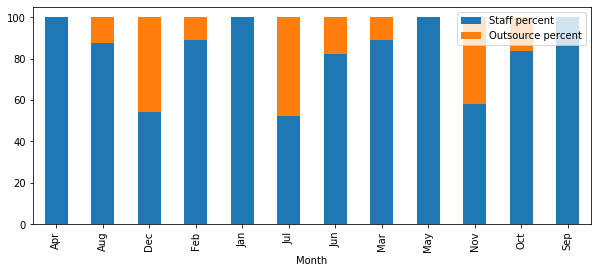

In [58]:
Outputstack.plot(x = 'Month', y = ['Staff percent','Outsource percent'], kind = 'bar', stacked = True, figsize = (10,4))

### Stacked bar wrt each state

In [59]:
Output['total'] = Output['Applications processed by staff'] + Output['Number of Outsource']
Output['Staff percent'] = Output['Applications processed by staff']/Output['total']*100
Output['Outsource percent'] = Output['Number of Outsource']/Output['total']*100


Output


,State,Month,Number of FTEs,Number of Outsource,Total Monthly Cost,Applications processed by staff,total,Staff percent,Outsource percent
0,A,Jan,161.728395,0.0,808641.975309,5240.0,5240.0,100.000000,0.000000
1,A,Feb,160.460526,0.0,802302.631579,4878.0,4878.0,100.000000,0.000000
2,A,Mar,198.066667,0.0,990333.333333,5942.0,5942.0,100.000000,0.000000
3,A,Apr,71.781250,0.0,358906.250000,2297.0,2297.0,100.000000,0.000000
4,A,May,63.846154,0.0,319230.769231,1992.0,1992.0,100.000000,0.000000
5,A,Jun,77.910959,0.0,389554.794521,2275.0,2275.0,100.000000,0.000000
6,A,Jul,137.279412,1600.0,974397.058824,3734.0,5334.0,70.003750,29.996250
7,A,Aug,110.888158,0.0,554440.789474,3371.0,3371.0,100.000000,0.000000
8,A,Sep,116.018519,0.0,580092.592593,3759.0,3759.0,100.000000,0.000000
9,A,Oct,120.856164,0.0,604280.821918,3529.0,3529.0,100.000000,0.000000


In [60]:
print('Average cost per application', round(Output['Total Monthly Cost'].sum()/Output['total'].sum(),2))
print('Percentage of applications processed by staff', round(Output['Applications processed by staff'].sum()/Output['total'].sum()*100,2))
print('Percentage of applications Outsourced', round(Output['Number of Outsource'].sum()/Output['total'].sum()*100,2))

Average cost per application 158.55
Percentage of applications processed by staff 81.69
Percentage of applications Outsourced 18.31


State
A    AxesSubplot(0.125,0.125;0.775x0.755)
B    AxesSubplot(0.125,0.125;0.775x0.755)
C    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

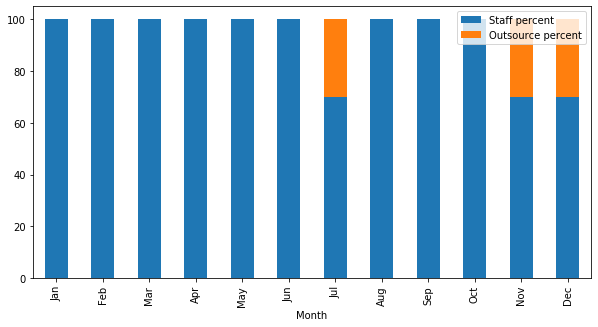

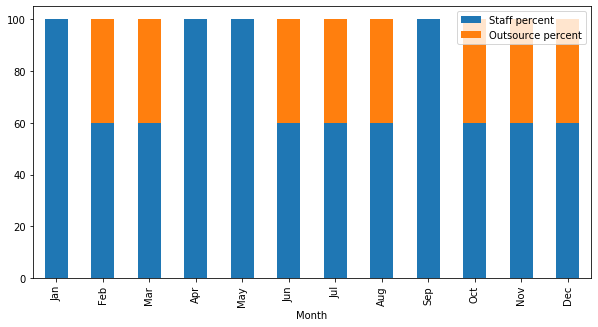

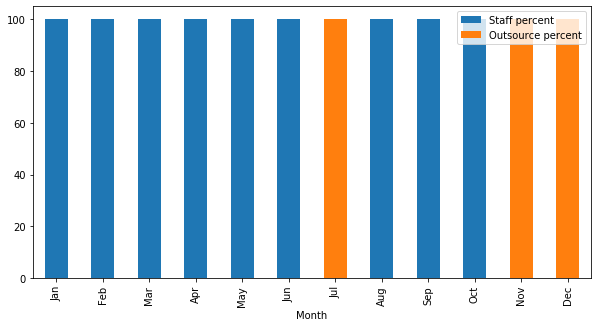

In [61]:
Output.groupby(['State']).plot(x="Month", y=['Staff percent','Outsource percent'], kind="bar",figsize=(10,5), stacked=True)

### Graphs wrt cost per application

In [62]:
Output['Cost per app'] = Output['Total Monthly Cost']/Output['total']
Output.head()

,State,Month,Number of FTEs,Number of Outsource,Total Monthly Cost,Applications processed by staff,total,Staff percent,Outsource percent,Cost per app
0,A,Jan,161.728395,0.0,808641.975309,5240.0,5240.0,100.0,0.0,154.320988
1,A,Feb,160.460526,0.0,802302.631579,4878.0,4878.0,100.0,0.0,164.473684
2,A,Mar,198.066667,0.0,990333.333333,5942.0,5942.0,100.0,0.0,166.666667
3,A,Apr,71.781250,0.0,358906.250000,2297.0,2297.0,100.0,0.0,156.250000
4,A,May,63.846154,0.0,319230.769231,1992.0,1992.0,100.0,0.0,160.256410


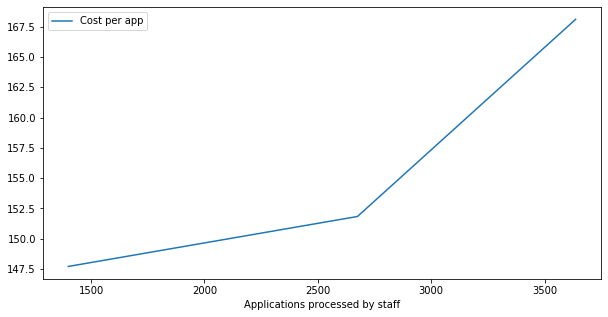

In [63]:
Output.groupby(['State']).mean().plot(x = 'Applications processed by staff', y ='Cost per app', figsize = (10,5))

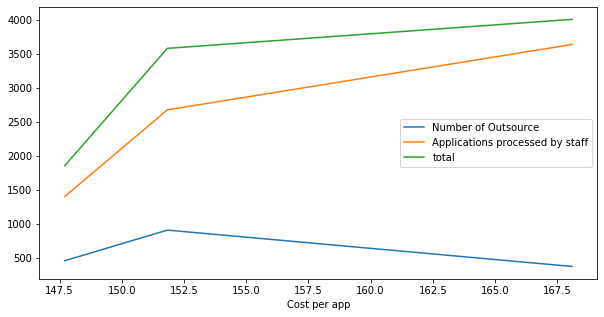

In [64]:
Output.groupby(['State']).mean().plot(y = ['Number of Outsource','Applications processed by staff','total'], x ='Cost per app', figsize = (10,5))

#### Worst case scenario

In [65]:
Output_worst['total'] = Output_worst['Applications processed by staff'] + Output_worst['Number of Outsource']
Output_worst['Staff percent'] = Output_worst['Applications processed by staff']/Output_worst['total']*100
Output_worst['Outsource percent'] = Output_worst['Number of Outsource']/Output_worst['total']*100
Output_worst['Cost per app'] = Output_worst['Total Monthly Cost']/Output_worst['total']
Output_worst.head()


,State,Month,Number of FTEs,Number of Outsource,Total Monthly Cost,Applications processed by staff,total,Staff percent,Outsource percent,Cost per app
0,A,Jan,187.142857,0.0,9.357143e+05,5240.0,5240.0,100.0000,0.0000,178.571429
1,A,Feb,131.346154,1463.0,9.200708e+05,3415.0,4878.0,70.0082,29.9918,188.616394
2,A,Mar,212.214286,0.0,1.061071e+06,5942.0,5942.0,100.0000,0.0000,178.571429
3,A,Apr,76.566667,0.0,3.828333e+05,2297.0,2297.0,100.0000,0.0000,166.666667
4,A,May,71.142857,0.0,3.557143e+05,1992.0,1992.0,100.0000,0.0000,178.571429


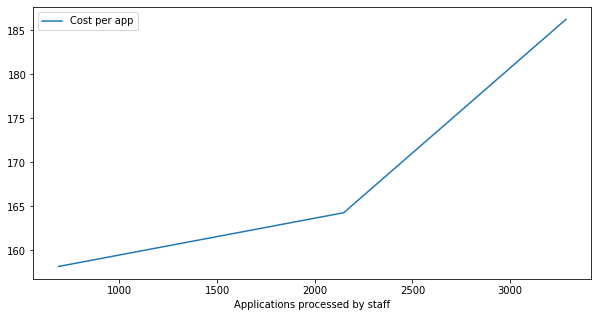

In [66]:
Output_worst.groupby(['State']).mean().plot(x = 'Applications processed by staff', y ='Cost per app', figsize = (10,5))

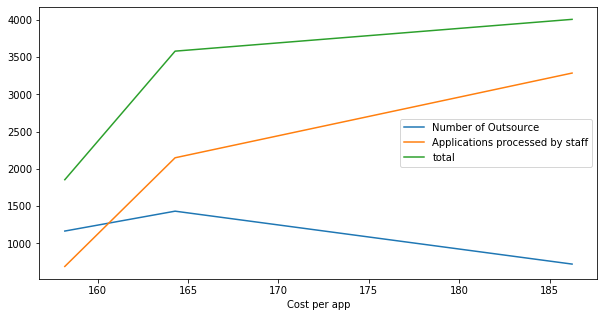

In [67]:
Output_worst.groupby(['State']).mean().plot(y = ['Number of Outsource','Applications processed by staff','total'], x ='Cost per app', figsize = (10,5))

#### Best case scenario

In [68]:
Output_best['total'] = Output_best['Applications processed by staff'] + Output_best['Number of Outsource']
Output_best['Staff percent'] = Output_best['Applications processed by staff']/Output_best['total']*100
Output_best['Outsource percent'] = Output_best['Number of Outsource']/Output_best['total']*100
Output_best['Cost per app'] = Output_best['Total Monthly Cost']/Output_best['total']
Output_best.head()


,State,Month,Number of FTEs,Number of Outsource,Total Monthly Cost,Applications processed by staff,total,Staff percent,Outsource percent,Cost per app
0,A,Jan,145.555556,0.0,727777.777778,5240.0,5240.0,100.0,0.0,138.888889
1,A,Feb,143.470588,0.0,717352.941176,4878.0,4878.0,100.0,0.0,147.058824
2,A,Mar,185.687500,0.0,928437.500000,5942.0,5942.0,100.0,0.0,156.250000
3,A,Apr,67.558824,0.0,337794.117647,2297.0,2297.0,100.0,0.0,147.058824
4,A,May,58.588235,0.0,292941.176471,1992.0,1992.0,100.0,0.0,147.058824


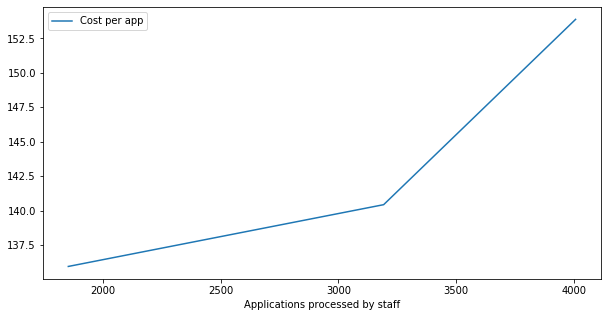

In [69]:
Output_best.groupby(['State']).mean().plot(x = 'Applications processed by staff', y ='Cost per app', figsize = (10,5))

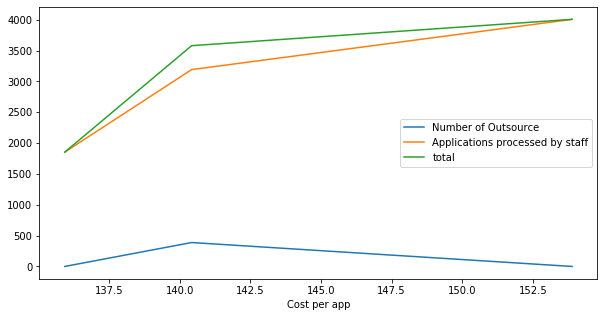

In [70]:
Output_best.groupby(['State']).mean().plot(y = ['Number of Outsource','Applications processed by staff','total'], x ='Cost per app', figsize = (10,5))

Recommendations and key insights are attached in the report. 